In [1]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from onc import ONC
import xarray as xr

# Import common code from the python-community-notebooks repository.
from pcn_common import get_onc_token_from_netrc,format_datetime, convert_scalar_data, split_periods, identify_transit_ports

In [2]:
token = get_onc_token_from_netrc(machine = 'data.oceannetworks.ca')
onc = ONC(token = token)

In [3]:
date_from = datetime(2025,11,3,9,0,0)
date_to = datetime(2025,11,3,20,15,0)

# Download NAV
params = {'locationCode': 'TWDP.N1',
          'deviceCategoryCode': 'NAV',
          'qualityControl': 'clean',
          'dateFrom': format_datetime(date_from),
          'dateTo': format_datetime(date_to),
          'fillGaps': False}
json_response = onc.getScalardata(filters = params, allPages=True)
nav = convert_scalar_data(json_response_data = json_response, out_as = 'xarray')


# Download TSG
params = {'locationCode': 'TWDP',
          'deviceCategoryCode': 'TSG',
          'qualityControl': 'clean',
          'dateFrom': format_datetime(date_from),
          'dateTo': format_datetime(date_to),
          'fillGaps': False}
json_response = onc.getScalardata(filters = params, allPages=True)
tsg = convert_scalar_data(json_response_data=json_response, out_as = 'xarray')

## Combine and Interpolate Lat/Lon

In [4]:
ds = xr.combine_by_coords([nav, tsg], combine_attrs = 'drop_conflicts', join = 'outer')

# Linearly interpolate to nearest position. For simplicity, we do not assume a time-lag.
ds['latitude'] = ds['latitude'].interpolate_na(dim = 'time', method = 'linear', max_gap = timedelta(seconds = 5), fill_value = 'extrapolate')
ds['longitude'] = ds['longitude'].interpolate_na(dim = 'time', method = 'linear', max_gap = timedelta(seconds = 5), fill_value = 'extrapolate')

ds = ds.sel(time = tsg.time)  # Select the original TSG timestamps.
ds = ds[['latitude', 'longitude', 'temperature','practical_salinity']]

## Split Transits By Time Gaps

In [5]:
transit_times = split_periods(ds.time, min_gap = 60*5)
transits = [ds.sel(time = slice(t['dateFrom'], t['dateTo'])) for t in transit_times]

# Apply median filter with a window size of 13 samples to each transit.
transits = [t.rolling({'time': 13}, center = True, min_periods = 1).median() for t in transits]

## Plot of Example Transit

Text(0.5, 1.0, '2025-11-03T18:17:06.390')

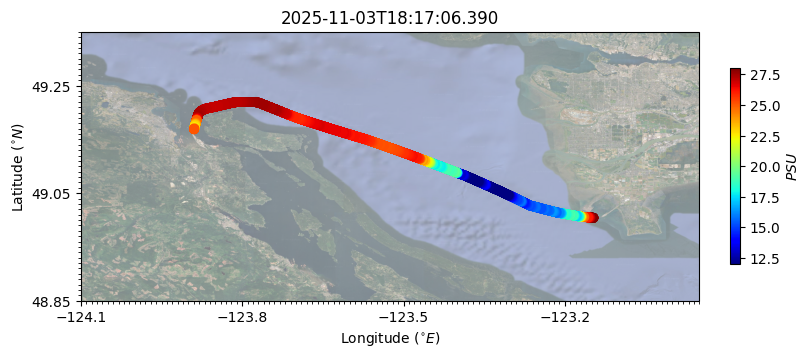

In [6]:
example_transit = transits[-1]

crs = ccrs.PlateCarree()
tile = cimgt.GoogleTiles(style = 'satellite')

lon_min = -124.1
lon_max = -122.95
lat_min = 48.85
lat_max = 49.35

fig, ax = plt.subplots(1,1, figsize = (8,4), constrained_layout = True, subplot_kw = {'projection' : crs})

ax.set_extent([lon_min, lon_max, lat_min , lat_max])
ax.add_image(tile,12,alpha = 0.5)
ax.set_xticks(np.arange(lon_min, lon_max,0.3))
ax.xaxis.set_minor_locator(MultipleLocator(0.01))
ax.set_yticks(np.arange(lat_min, lat_max,0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.set_xlabel(r'Longitude ($^{\circ}E$)')
ax.set_xlabel(r'Longitude ($^{\circ}E$)')
ax.set_ylabel(r'Latitude ($^{\circ}N$)')
ax.set_ylabel(r'Latitude ($^{\circ}N$)')

s0 = ax.scatter(example_transit.longitude, example_transit.latitude, c = example_transit.practical_salinity, cmap = 'jet', transform = crs, vmin = 12, vmax = 28)

fig.colorbar(s0, ax = ax, label = r'$PSU$', shrink = 0.5)

ax.set_title(example_transit.time.min().values)

## Determine Transit Origin

In [7]:
for transit in transits:
    start, end = identify_transit_ports(transit.latitude, transit.longitude)
    print(transit.time.min().values, start, end)

2025-11-03T13:18:00.296 Tsawwassen DukePoint
2025-11-03T15:47:06.338 DukePoint Tsawwassen
2025-11-03T18:17:06.390 Tsawwassen DukePoint
